## VODAFONE CUSTOMER CHURN PREDICTION

### Business Understanding
The objective of the project is to build a machine learning model that predicts customer churn.

### Project Description
Telecommunications sector is concerned with retaining customers due to the high costs associated with acquiring new ones. Customer churn, or turnover, occurs when customers cease their subscriptions or services. This can result in lost revenue and necessitate additional marketing expenditures to attract new clients.
To address this challenge, the project involves leveraging data analytics techniques and machine learning to analyze service usage patterns and predict customer churn


### Questions
 -Is there a relationship between Churn and monthly charges/ does increase in monthly charges leads to churn?
 
 -What is the number of those who churn?

 -What is the relationship between churn and tenure?



### Hypothesis
H0: There is no significant correlation between MonthlyCharges and customer churn

HA: There is  significant correlation between MonthlyCharges and customer churn

### Data Understanding
 
The following describes the columns present in the data.

Gender -- Whether the customer is a male or a female

SeniorCitizen -- Whether a customer is a senior citizen or not

Partner -- Whether the customer has a partner or not (Yes, No)

Dependents -- Whether the customer has dependents or not (Yes, No)

Tenure -- Number of months the customer has stayed with the company

Phone Service -- Whether the customer has a phone service or not (Yes, No)

MultipleLines -- Whether the customer has multiple lines or not

InternetService -- Customer's internet service provider (DSL, Fiber Optic, No)

OnlineSecurity -- Whether the customer has online security or not (Yes, No, No Internet)

OnlineBackup -- Whether the customer has online backup or not (Yes, No, No Internet)

DeviceProtection -- Whether the customer has device protection or not (Yes, No, No internet service)

TechSupport -- Whether the customer has tech support or not (Yes, No, No internet)

StreamingTV -- Whether the customer has streaming TV or not (Yes, No, No internet service)

StreamingMovies -- Whether the customer has streaming movies or not (Yes, No, No Internet service)

Contract -- The contract term of the customer (Month-to-Month, One year, Two year)

PaperlessBilling -- Whether the customer has paperless billing or not (Yes, No)

Payment Method -- The customer's payment method (Electronic check, mailed check, Bank transfer(automatic), Credit card(automatic))

MonthlyCharges -- The amount charged to the customer monthly

TotalCharges -- The total amount charged to the customer

Churn -- Whether the customer churned or not (Yes or No)

In [85]:
# importing  libraries
import pyodbc 
from dotenv import dotenv_values 
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import numpy as np
import re
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from scipy.stats import ttest_ind
from scipy.stats import pearsonr

warnings.filterwarnings('ignore')


In [2]:
# loading environment variables
environment_variables = dotenv_values('.env')
 
# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [4]:
connection = pyodbc.connect(connection_string)

### Loadind Data

In [5]:
# Loading dataset 1 for training & evaluation
query = "select * from dbo.LP2_Telco_churn_first_3000" 

train_data1 = pd.read_sql(query, connection)




In [6]:
# converting database data  to csv file
#train_data1.to_csv('train1.csv')

In [7]:
# loading dataset 2 for training & evaluation
train_data2 = pd.read_csv('./data_customer Churn/LP2_Telco-churn-second-2000.csv')

In [8]:
test_data = pd.read_excel('./data_customer Churn/Telco-churn-last-2000.xlsx')

### Reading Data

In [9]:
train_data1.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True


In [10]:
train_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [11]:
train_data2.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No


### EDA

In [12]:
train_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [13]:
test_data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55


### Merging Data

In [14]:
# merging dataset
df = pd.concat([train_data1, train_data2])

In [15]:
#df.to_csv('merged_data.csv')

In [16]:
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True


### Exploratory Data Analysis

In [17]:
# checking data information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 
 17  

### Cleaning Data

In [18]:
# change column title to lower case
df.columns=df.columns.str.lower()

In [19]:
df.drop('customerid', axis=1, inplace=True)


In [20]:
# Replace True, False with Yes & No
replacement_dict = {
    True: 'Yes',
    False: 'No',
    'No phone service': 'No',
    'No internet service': 'No'
}

df.replace(replacement_dict, inplace=True)

In [21]:
# replacing string 
df['totalcharges']=df['totalcharges'].replace(" ", np.nan)

In [22]:
# changing datatype of TotalCharges Column to numeric
df['totalcharges']= pd.to_numeric(df['totalcharges'])

In [23]:
df_copy=df.copy()

In [24]:
# checking for null values
df.isnull().sum()

gender                0
seniorcitizen         0
partner               0
dependents            0
tenure                0
phoneservice          0
multiplelines       269
internetservice       0
onlinesecurity      651
onlinebackup        651
deviceprotection    651
techsupport         651
streamingtv         651
streamingmovies     651
contract              0
paperlessbilling      0
paymentmethod         0
monthlycharges        0
totalcharges          8
churn                 1
dtype: int64

### Handling missing values

-It was observed that those without phone service automatically did not have multiple lines hence the missing values in that column
-No will therefore be used to fill the missing values

-Those without internet service also did not have onlinesecurity, onlinebackup, Device protection, streamingmovies, streamingTv, Techsupport
-No will therefore be used to fill the missing values

Total Charges is observed to be aa product of the tenure and monthly charge. The Assumption is that the missing values are those with less than a month tenure
Total charge for a month will be used to fill the missing values




In [25]:
 # Filling  missing values with 'no'
col_to_fill = ['multiplelines', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']
for items in col_to_fill:
   if df[items].isna().any() == True:
        df[items] = df[items].fillna('No')

In [26]:
#Creating a mask variable for the missing values in the column for totalcharges
mask = df['totalcharges'].isna()
 
# Filling the missing values of totalcharge with the values of the monthlycharge
df['totalcharges'].fillna(df.loc[mask,'monthlycharges'], inplace = True)
 

In [27]:
# Filling the missing value in the churn column with mode
mode_churn = df['churn'].mode()[0]
df['churn'] = df['churn'].fillna(mode_churn)
 

In [28]:
df.isna().sum()

gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [29]:
#Check duplicates
df.duplicated().sum()

10

In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
seniorcitizen,5043.0,0.162403,0.368857,0.000000,0.000000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.000000,9.000000,29.000000,56.000000,72.000000
monthlycharges,5043.0,65.090214,30.068133,18.400000,35.775000,70.550003,90.050003,118.650002
totalcharges,5043.0,2298.488381,2269.455293,18.799999,415.724997,1398.599976,3857.575073,8670.100000


In [84]:
df.to_csv('clean_data.csv')

### Observations
The features are not on the same scale as observed by TotalCharges column

There is an imbalance in the data

In [31]:
# create a list of numeric columns
numerics = []
for column in df.columns:
    if df[column].dtype != "O":
        numerics.append(column)
numerics

['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges']

In [32]:
# create a list of categorical columns
categoricals = []
for column in df.columns:
    if df[column].dtype == "O":
        categoricals.append(column)
categoricals

['gender',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'churn']

### Univariate Analysis

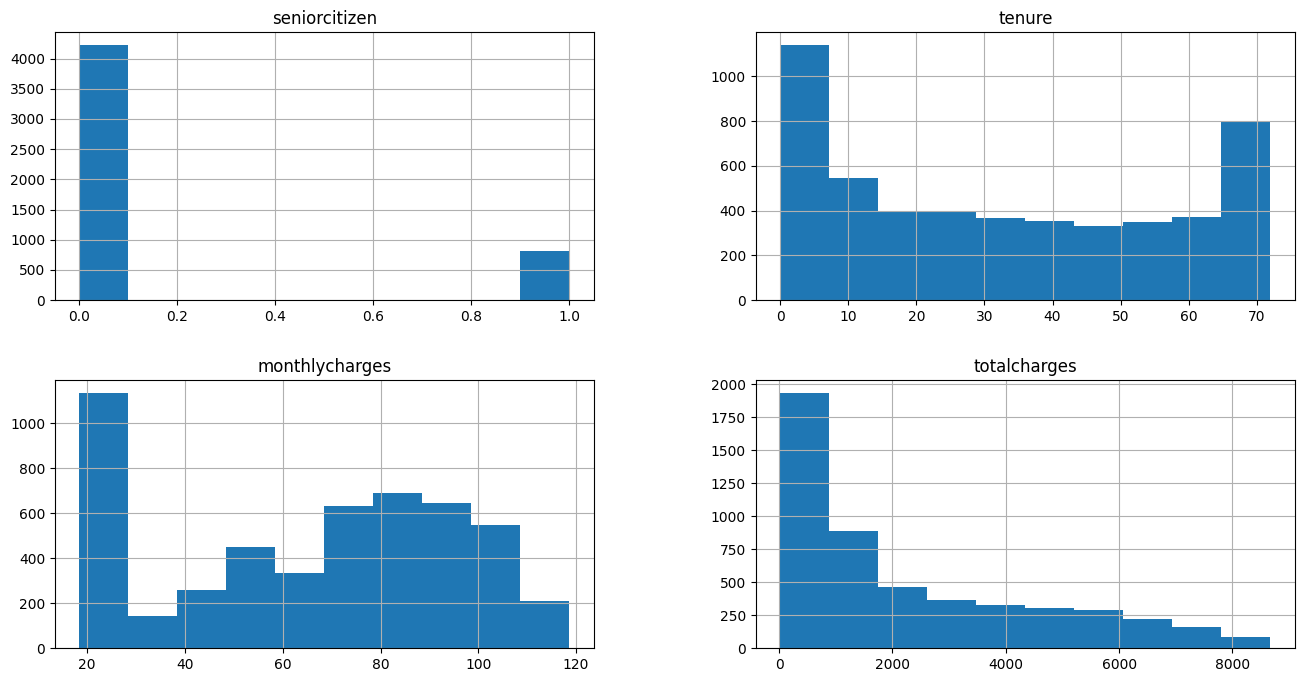

In [33]:
df.hist(figsize=(16,8))
plt.show()

### Bivariate Analysis

In [34]:
# visualizing distribution of categorical columns
figsize = (700, 500)

for column in categoricals:
    
    
    #Visualize the raw numbers of relative churn rates
    fig = px.histogram(df, x=df[column], text_auto=True, color=df["churn"],
                       
                       barnorm="percent", barmode="relative",
                       title=f"Percentage of customers who churn by {column} ")
                   
    fig.update_layout(width=figsize[0], height=figsize[1])
    
    fig.show()

    

In [35]:
fig = px.histogram(df, x=df['churn'], text_auto=True, color=df["churn"],

title=f"Number of customers who churn")  

fig.show()

### Multivariate Analysis

In [36]:
# Visualize relationships between variables
## Calculate the correlations
corr_matrix = df.corr(numeric_only=True)

## Visualize the correlations 
fig = px.imshow(corr_matrix, text_auto=True, width = 1080, height = 760,
                title= f"correlation matrix")
fig.show()

### Observations
From the correlation matrix above, tenure and total charges have a significant relationship due to the coeficient being close to 1

Again, monthly charge and total charges also have a significant relationship

### Answering Questions

### QU Is there a relationship between churn and monthly charge

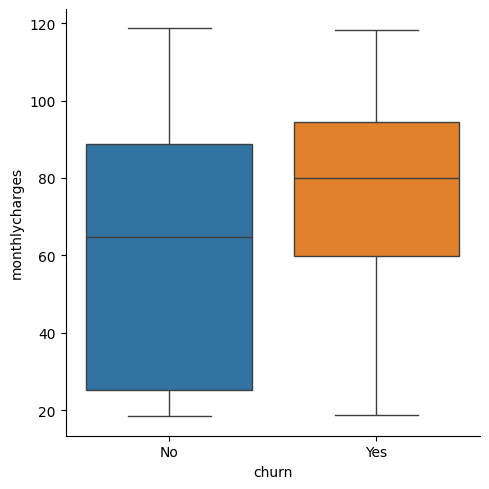

In [37]:
#MonthlyCharges relation with churn
sns.catplot(data= df, x='churn',y='monthlycharges',kind='box', hue='churn')

From the above, it is observed that customers who left had higher monthly charges

### QU What is the number of Customers who churn

In [38]:
# Number who churn
fig = px.histogram(df, x=df['churn'], text_auto=True, color=df["churn"],

title=f"Number of customers who churn")  

fig.show()

From the customer base, 1336 customers stopped patronizing the service

### Qu What is the relationship between churn and tenure

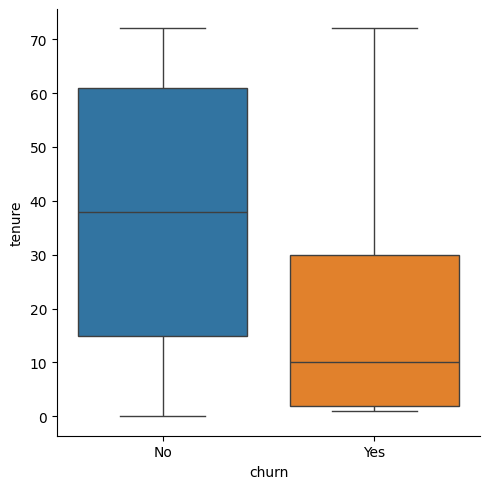

In [39]:
# churn by tenure
sns.catplot(data= df, x='churn',y='tenure',kind='box', hue='churn')

It is observed that most of the customers who left have not been with the Organization for too long, the average being 10months

### QU What is the churn distribution based on contract type

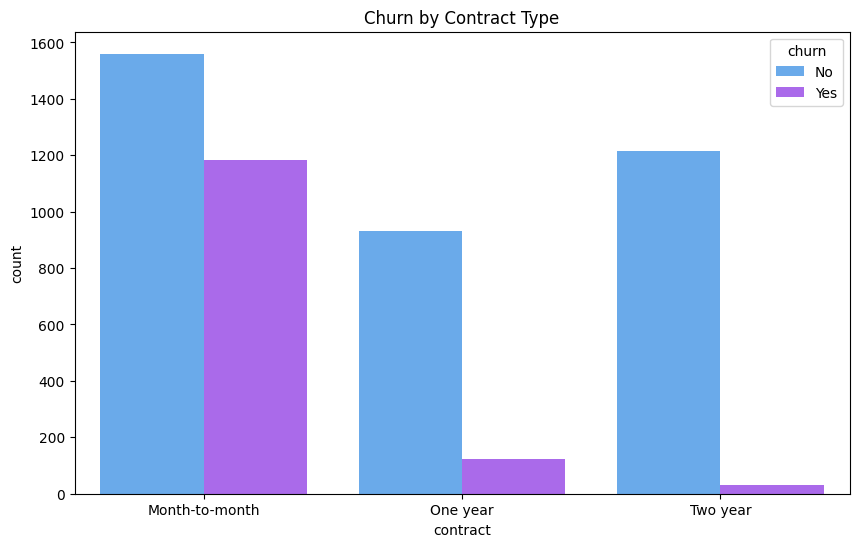

In [98]:
plt.figure(figsize=(10, 6))  # Set the size of the plot
sns.countplot(x="contract", hue="churn", data=df, palette="cool")  
plt.title("Churn by Contract Type")  # Add title to the plot
plt.show()

### QU What is the churn distribution based on internet service

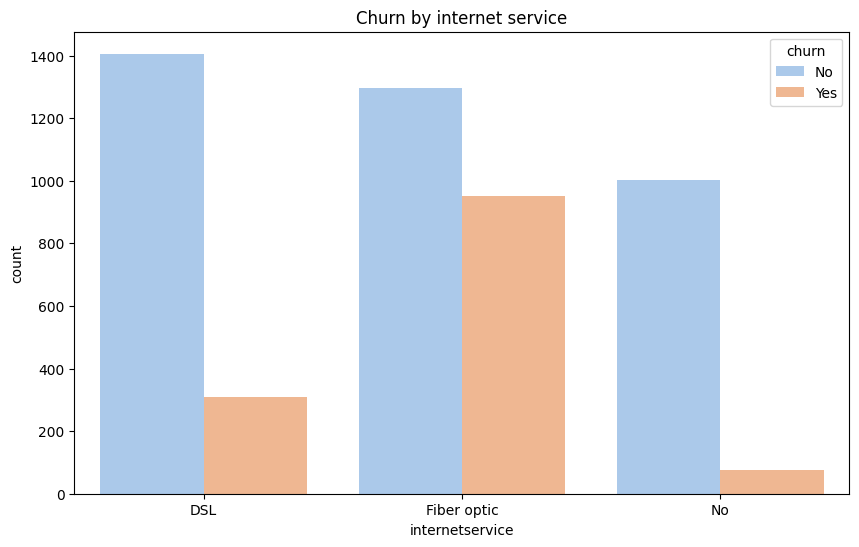

In [100]:
plt.figure(figsize=(10, 6))  # Set the size of the plot
sns.countplot(x="internetservice", hue="churn", data=df, palette="pastel")  
plt.title("Churn by internet service")  # Add title to the plot
plt.show()

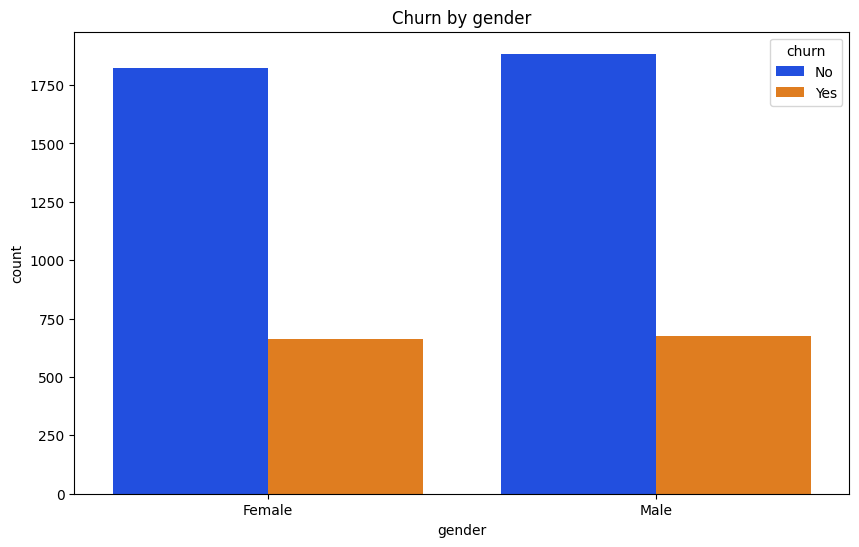

In [101]:
plt.figure(figsize=(10, 6))  # Set the size of the plot
sns.countplot(x="gender", hue="churn", data=df, palette="bright")  
plt.title("Churn by gender")  # Add title to the plot
plt.show()

### QU How many customers churned as a result of paymentmethod

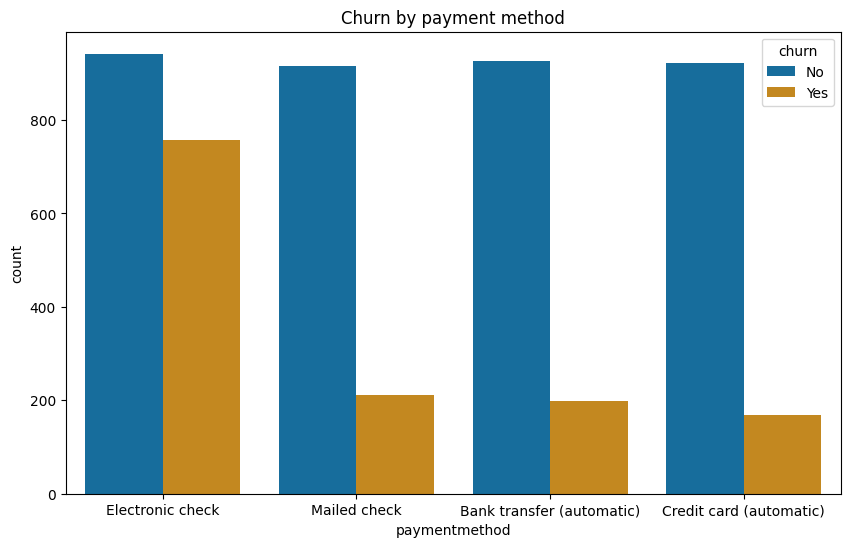

In [102]:
plt.figure(figsize=(10, 6))  
sns.countplot(x="paymentmethod", hue="churn", data=df, palette="colorblind")  
plt.title("Churn by payment method") 
plt.show()

### HYPOTHESIS TESTING

H0: There is no significant correlation between MonthlyCharges and customer churn

HA: There is  significant correlation between MonthlyCharges and customer churn

In [40]:


# Assuming df is your DataFrame and 'churn' is the column you want to encode

label_encoder = LabelEncoder()
df['churn_encoded'] = label_encoder.fit_transform(df['churn'])


In [41]:

MonthlyCharges = df['monthlycharges']

churn_data = df['churn_encoded']

correlation_coefficient, p_value = pearsonr(MonthlyCharges, churn_data)



print("Pearson correlation coefficient:", correlation_coefficient)
print("p-value:", p_value)

# Set Significance level
alpha = 0.05
 
#Compare p-value to the significance level
if p_value < alpha:
    print("We reject the null hypothesis. There is no significant correlation between MonthlyCharges and customer churn.")
else:
   print("We failed to reject the null hypothesis. There is no significant correlation between MonthlyCharges and customer churn.")


Pearson correlation coefficient: 0.20208910644737807
p-value: 1.257546511353108e-47
We reject the null hypothesis. There is no significant correlation between MonthlyCharges and customer churn.


### DATA PREPARATION

In [42]:
categoricals.remove('churn')

### checking for balanced data

In [43]:
# checking the class distribution 

class_distro=df['churn'].value_counts().rename('Total').reset_index()
class_distro

,churn,Total
0,No,3707
1,Yes,1336


In [44]:
# check ratio of class distribution
class_distro['Ratio'] = class_distro['Total'].apply(lambda x: round((x/class_distro['Total'].sum()*100),2))
class_distro

,churn,Total,Ratio
0,No,3707,73.51
1,Yes,1336,26.49


### **SPLIT DATA**

In [45]:
# Set X and y
X = df.drop(columns = "churn", axis=1, inplace= False)
y = df["churn"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

In [46]:
# encoding y label

encoder= LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [47]:
y_train_encoded

array([1, 0, 1, ..., 0, 0, 0])

### PIPELINE

In [79]:

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ("scaler", RobustScaler())

])

categorical_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
                                          

])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerics),
    ("cat", categorical_transformer, categoricals)

])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', RobustScaler())]),
                                 ['seniorcitizen', 'tenure', 'monthlycharges',
                                  'totalcharges']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['gender', 'partner', 'dependents',
                                  'phoneservice', 'multiplelines',
                                  'internetservice', 'onlinesecurity',
                                  'onlinebackup', 'deviceprotection',
                                  'techsupport', 'streamingtv',
                                  'streamingmovies', 'contract',
                                  'paperlessbilling', 'paymentmethod'])])

### **`MODELLING & EVALUATION`**

In [49]:
models = [
    ('Decision_Tree', DecisionTreeClassifier(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Random Forest', RandomForestClassifier(random_state=42))
]

In [70]:
all_pipelines ={}

all_confusion_matrix ={}

metric_table = pd.DataFrame(columns =['model_name', 'accuracy', 'precision','recall', 'f1_score'])

for model_name, classifier in models:

    final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)

    ])

    final_pipeline.fit(X_train, y_train_encoded)

    all_pipelines[model_name]=final_pipeline

  # Predicting on the test set
    y_pred= final_pipeline.predict(X_test)

    conf_matrix = confusion_matrix(y_test_encoded, y_pred)

    #Add confusion matrix into the all_pipeline dictionary
    all_confusion_matrix[model_name]= conf_matrix



 # generate classification report for each pipeline or model
    metrics= classification_report(y_test_encoded, y_pred, output_dict = True)


    accuracy = metrics['accuracy']
    precision = metrics['weighted avg']['precision']
    recall  = metrics['weighted avg']['recall']
    f1 = metrics['weighted avg']['f1-score']

    metric_table.loc[len(metric_table)]=[model_name, accuracy, precision, recall, f1]

    
    

### Evaluation

In [51]:
metric_table

,model_name,accuracy,precision,recall,f1_score
0,Decision_Tree,0.707631,0.719467,0.707631,0.712815
1,Logistic Regression,0.799802,0.795386,0.799802,0.797238
2,KNN,0.748266,0.746474,0.748266,0.747342
3,Random Forest,0.793855,0.785815,0.793855,0.788532


In [52]:
metric_table.sort_values(by='f1_score', ascending = False)

,model_name,accuracy,precision,recall,f1_score
1,Logistic Regression,0.799802,0.795386,0.799802,0.797238
3,Random Forest,0.793855,0.785815,0.793855,0.788532
2,KNN,0.748266,0.746474,0.748266,0.747342
0,Decision_Tree,0.707631,0.719467,0.707631,0.712815


### CONFUSION MATRIX FOR UNBALANCED DATA

In [71]:
logistic_matrix  = all_confusion_matrix['Logistic Regression']
logistic_matrix

array([[651,  91],
       [111, 156]], dtype=int64)

<Axes: >

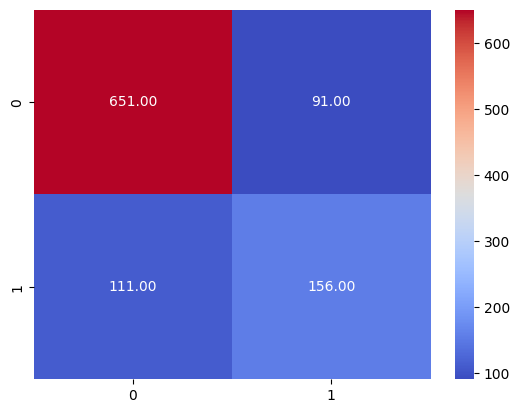

In [72]:
sns.heatmap(logistic_matrix, annot=True, cmap='coolwarm', fmt='.2f')

### **TRAIN ON BALANCED DATA**

In [73]:
# hold trained models in all balanced pipeline
all_balanced_pipelines ={}

all_confusion_matrix ={}

# Data frame to store all model metrics
balanced_metric_table = pd.DataFrame(columns =['model_name', 'accuracy', 'precision','recall', 'f1_score'])

for model_name, classifier in models:

    # create final balanced pipeline with preprocessor and estimator
    balanced_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote-sampler', SMOTE(random_state=0)),
        ('feature-selection', SelectKBest(mutual_info_classif, k='all')),
        ('classifier', classifier)

    ])

    #Fit data to pipeline
    balanced_pipeline.fit(X_train, y_train_encoded)

    # add all pipelines into all_pipeline dictionary
    all_balanced_pipelines[model_name]=balanced_pipeline

  # Predicting on the test set
    y_pred= balanced_pipeline.predict(X_test)

    conf_matrix = confusion_matrix(y_test_encoded, y_pred)

    #Add confusion matrix into the all_pipeline dictionary
    all_confusion_matrix[model_name]= conf_matrix



  # generate classification report for each pipeline or model
    balanced_metrics= classification_report(y_test_encoded, y_pred, output_dict = True)


    accuracy = balanced_metrics['accuracy']
    precision = balanced_metrics['weighted avg']['precision']
    recall  = balanced_metrics['weighted avg']['recall']
    f1 = balanced_metrics['weighted avg']['f1-score']

    balanced_metric_table.loc[len(balanced_metric_table)]=[model_name, accuracy, precision, recall, f1]
    
    balanced_metric_table
    
balanced_metric_table.sort_values(by='f1_score', ascending=False)    

    
    

,model_name,accuracy,precision,recall,f1_score
3,Random Forest,0.783944,0.786068,0.783944,0.784953
1,Logistic Regression,0.736373,0.803111,0.736373,0.750966
0,Decision_Tree,0.737364,0.753923,0.737364,0.743917
2,KNN,0.691774,0.762194,0.691774,0.708946


### CONFUSION MATRIX FOR BALANCED DATA

In [76]:
forest_matrix  = all_confusion_matrix['Random Forest']
forest_matrix

array([[629, 113],
       [105, 162]], dtype=int64)

<Axes: >

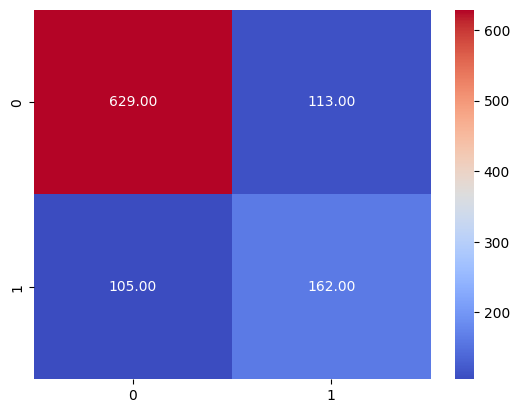

In [77]:
sns.heatmap(forest_matrix, annot=True, cmap='coolwarm', fmt='.2f')

### OBSERVATIONS

-After training the data on a balanced data, Random Forest emerged as the model with the highest F1-score

-The random forest F1-score for the balanced data is still lower than the logistic Regression F1-score for the unbalanced data

-Confusion matrix for balanced data & unbalanced data are not too different

-Therefore considering the F1-score of the unbalnced data, we shall stick to the logistic Regression model

### ROC CURVE

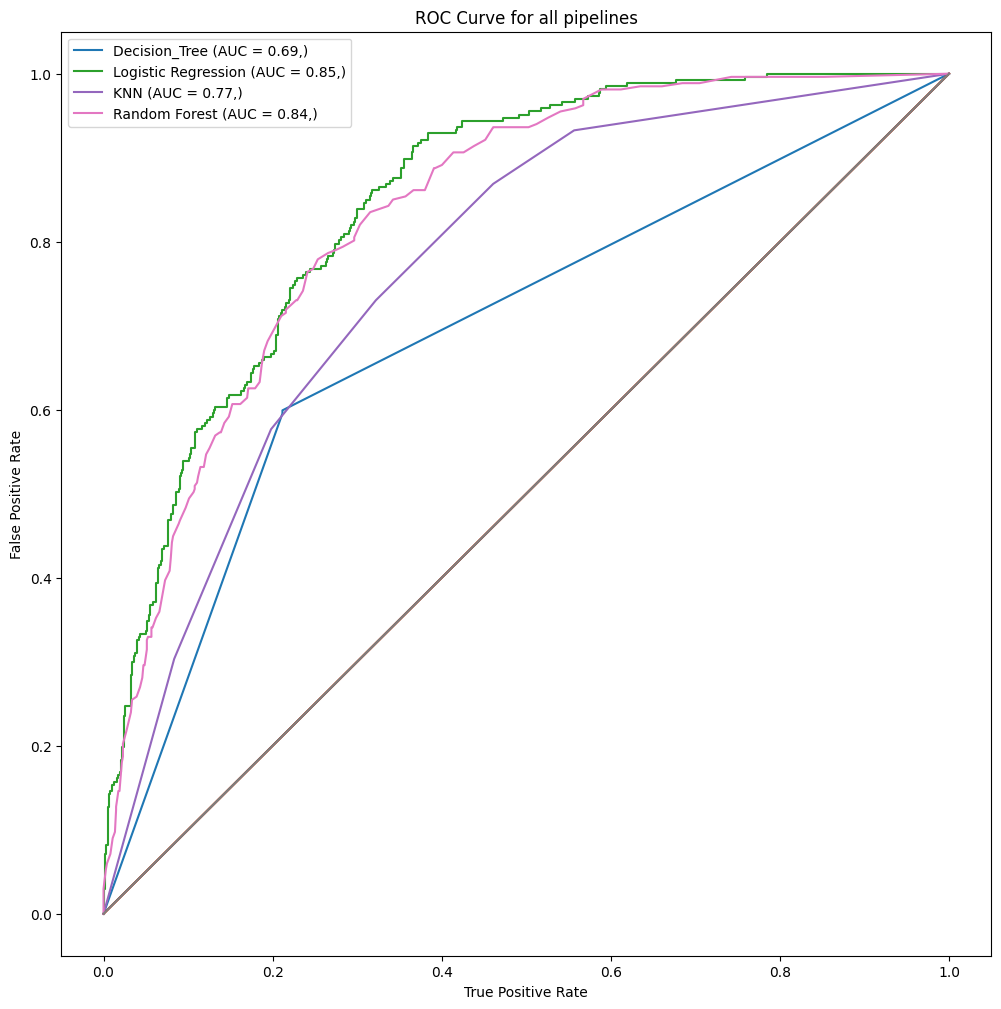

In [83]:
fig, ax = plt.subplots(figsize=(12, 12))

all_confusion_matrix = {}

all_roc_data = {}

for model_name, pipeline in all_pipelines.items():
    
    y_score = pipeline.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test_encoded, y_score)

    roc_auc = auc(fpr, tpr)

    roc_data_df = pd.DataFrame({'False Positive rate':fpr, 'True Positive Rate':tpr})

    all_roc_data[model_name] = roc_data_df

    ax.plot(fpr, tpr, label= f'{model_name} (AUC = {roc_auc:.2f},)')

    ax.plot([0,1],[0,1])
    ax.set_ylabel('False Positive Rate')
    ax.set_xlabel('True Positive Rate')
    ax.set_title('ROC Curve for all pipelines')

plt.legend()
plt.show()

### HYPERPARAMETER TUNING

In [95]:

metrics_list = []
# Dictionary containing hyperparameters to tune for each classifier
param_grid = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10]  
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],  
        'classifier__max_depth': [None, 10, 20]  
    },
    'Decision_Tree': {
        'classifier__max_depth': [None, 10, 20]  
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7]  
    }
}

# Iterate over each model
for model_name, classifier in models:
    # Create final balanced pipeline with preprocessor, SMOTE sampler, feature selection, and classifier
    balanced_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote-sampler', SMOTE(random_state=0)),
        ('feature-selection', SelectKBest(mutual_info_classif, k='all')),
        ('classifier', classifier)
    ])
    
    # Perform grid search with cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(balanced_pipeline, param_grid[model_name], cv=5, scoring='f1', n_jobs=-1)
    
    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train_encoded)
    
    # Get the best estimator (pipeline) from the grid search
    best_pipeline = grid_search.best_estimator_
    
    # Add the best pipeline to the dictionary of all balanced pipelines
    all_balanced_pipelines[model_name] = best_pipeline
    
    # Predict on the test set using the best pipeline
    y_pred = best_pipeline.predict(X_test)
    
    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_test_encoded, y_pred)
    
    # Add confusion matrix to the dictionary
    all_confusion_matrix[model_name] = conf_matrix
    
    # Generate classification report for the best pipeline or model
    balanced_metrics = classification_report(y_test_encoded, y_pred, output_dict=True)
    
    metrics_list.append([model_name,
                         balanced_metrics['accuracy'],
                         balanced_metrics['weighted avg']['precision'],
                         balanced_metrics['weighted avg']['recall'],
                         balanced_metrics['weighted avg']['f1-score']])

balanced_metric_table = pd.DataFrame(metrics_list, columns=['model_name', 'accuracy', 'precision', 'recall', 'f1_score'])
    
    
balanced_metric_table.sort_values(by='f1_score', ascending=False)    

    


,model_name,accuracy,precision,recall,f1_score
3,Random Forest,0.786918,0.806229,0.786918,0.793437
0,Decision_Tree,0.741328,0.773891,0.741328,0.751710
1,Logistic Regression,0.736373,0.803111,0.736373,0.750966
2,KNN,0.685828,0.766994,0.685828,0.703921


### CONCLUSION
In conclusion, leveraging machine learning techniques within the Crisp-DM framework enables organizations like Vodafone to anticipate and mitigate customer churn effectively. By understanding the underlying drivers of churn and deploying predictive models in operational settings, businesses can proactively retain customers and drive sustainable growth. Moving forward, ongoing refinement and integration of predictive analytics into business processes will be key to maintaining a competitive advantage in the dynamic telecommunications industr